In [47]:
!pip install -q -U sentence-transformers datasets

In [75]:
import json
import torch
import random
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

In [76]:
all_data = []
with open('triplets.jsonl', 'r') as f:
    for line in f:
        all_data.append(json.loads(line))

In [77]:
random.seed(42)
random.shuffle(all_data)
split = int(len(all_data) * 0.9)
train_data = all_data[:split]

In [78]:
train_examples = [
    InputExample(texts=[str(r['query']), str(r['pos']), str(r['neg'])])
    for r in train_data
]

In [79]:
model = SentenceTransformer("BAAI/bge-small-en-v1.5")
model.prompts = {}
model.default_prompt_name = None

In [80]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
inner_loss = losses.MultipleNegativesRankingLoss(model)
train_loss = losses.MatryoshkaLoss(model, inner_loss, matryoshka_dims=[384, 256, 128, 64])

In [81]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=int(len(train_dataloader) * 0.1),
    optimizer_params={'lr': 2e-5},
    show_progress_bar=True,
    use_amp=True,
    output_path="bge-small-academic"
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,2.997700


In [96]:
import shutil
from google.colab import files
shutil.make_archive("bge_academic_model", 'zip', "bge-small-academic")
files.download("bge_academic_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
from sentence_transformers import util

test_q = "Sample research question from your PDF"
test_p = "The correct answer chunk"

# Verify 128-dim truncation
emb_q = model.encode(test_q)[:128]
emb_p = model.encode(test_p)[:128]

score = util.cos_sim(emb_q, emb_p)
print(f"Similarity Score (128-dim): {score.item():.4f}")

Similarity Score (128-dim): 0.4613


In [86]:
import torch
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd

base_model = SentenceTransformer("BAAI/bge-small-en-v1.5")
custom_model = SentenceTransformer("bge-small-academic")

for m in [base_model, custom_model]:
    m.prompts = {}
    m.default_prompt_name = None
    m.set_pooling_include_prompt(False)

eval_samples = test_data[:100]
corpus_texts = [str(r['pos']) for r in test_data]

def run_benchmark(model, model_name, dim=128):
    hits_at_1 = 0
    reciprocal_ranks = []


    corpus_embeddings = model.encode(
        corpus_texts,
        convert_to_tensor=True,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    corpus_embeddings = corpus_embeddings[:, :dim]

    for sample in eval_samples:
        query = str(sample['query'])
        correct_text = str(sample['pos'])

        query_embedding = model.encode(
            [query],
            convert_to_tensor=True,
            show_progress_bar=False,
            normalize_embeddings=True
        )[0][:dim]

        cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
        correct_idx = corpus_texts.index(correct_text)

        top_results = torch.topk(cos_scores, k=len(corpus_texts))
        prediction_indices = top_results[1].tolist()

        rank = prediction_indices.index(correct_idx) + 1

        if rank == 1:
            hits_at_1 += 1
        reciprocal_ranks.append(1 / rank)

    return {
        "Model": model_name,
        "Hit Rate@1": f"{(hits_at_1 / len(eval_samples)) * 100:.2f}%",
        "MRR": f"{np.mean(reciprocal_ranks):.4f}"
    }

print("--- Starting Error-Free Benchmark (128-dim) ---")
base_results = run_benchmark(base_model, "Base BGE-Small")
custom_results = run_benchmark(custom_model, "Fine-tuned BGE")

df = pd.DataFrame([base_results, custom_results])
print("\n", df.to_string(index=False))

--- Starting Error-Free Benchmark (128-dim) ---


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]


          Model Hit Rate@1    MRR
Base BGE-Small     68.00% 0.7603
Fine-tuned BGE     82.00% 0.8797


In [95]:
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer("bge-small-academic")

query = "How does the proposed CNN architecture handle multi-spectral satellite noise?"

corpus = [
    "Our model utilizes a specialized noise-reduction layer within the CNN to filter multi-spectral interference in satellite imagery.", # CORRECT
    "Machine learning models often require large datasets to converge during the training phase of neural networks.",                   # RELATED BUT WRONG
    "The recipe for a perfect chocolate cake involves cocoa powder, flour, and a pinch of salt."                                     # COMPLETELY IRRELEVANT
]

query_emb = model.encode(query, convert_to_tensor=True)[:128]
corpus_embs = model.encode(corpus, convert_to_tensor=True)[:, :128]


cosine_scores = util.cos_sim(query_emb, corpus_embs)[0]

print(f"Query: {query}\n")
for i in range(len(corpus)):
    score = cosine_scores[i].item()
    status = "MATCH" if score > 0.4 else "LOW"
    print(f"[{status}] Score: {score:.4f} | Text: {corpus[i][:80]}...")

Query: How does the proposed CNN architecture handle multi-spectral satellite noise?

[MATCH] Score: 0.7648 | Text: Our model utilizes a specialized noise-reduction layer within the CNN to filter ...
[LOW] Score: 0.1912 | Text: Machine learning models often require large datasets to converge during the trai...
[LOW] Score: 0.1251 | Text: The recipe for a perfect chocolate cake involves cocoa powder, flour, and a pinc...


In [ ]:
base_model = SentenceTransformer("BAAI/bge-small-en-v1.5")
custom_model = SentenceTransformer("bge-small-academic")

--- Benchmarking Base Model ---
Encoding corpus and queries...
  > Dim 64: HitRate=58.0%, MRR=0.6627
  > Dim 128: HitRate=68.0%, MRR=0.7603
  > Dim 256: HitRate=72.0%, MRR=0.7997
  > Dim 384: HitRate=74.0%, MRR=0.8243

--- Benchmarking Fine-Tuned Model ---
Encoding corpus and queries...
  > Dim 64: HitRate=74.0%, MRR=0.8091
  > Dim 128: HitRate=82.0%, MRR=0.8797
  > Dim 256: HitRate=86.0%, MRR=0.9156
  > Dim 384: HitRate=88.0%, MRR=0.9264


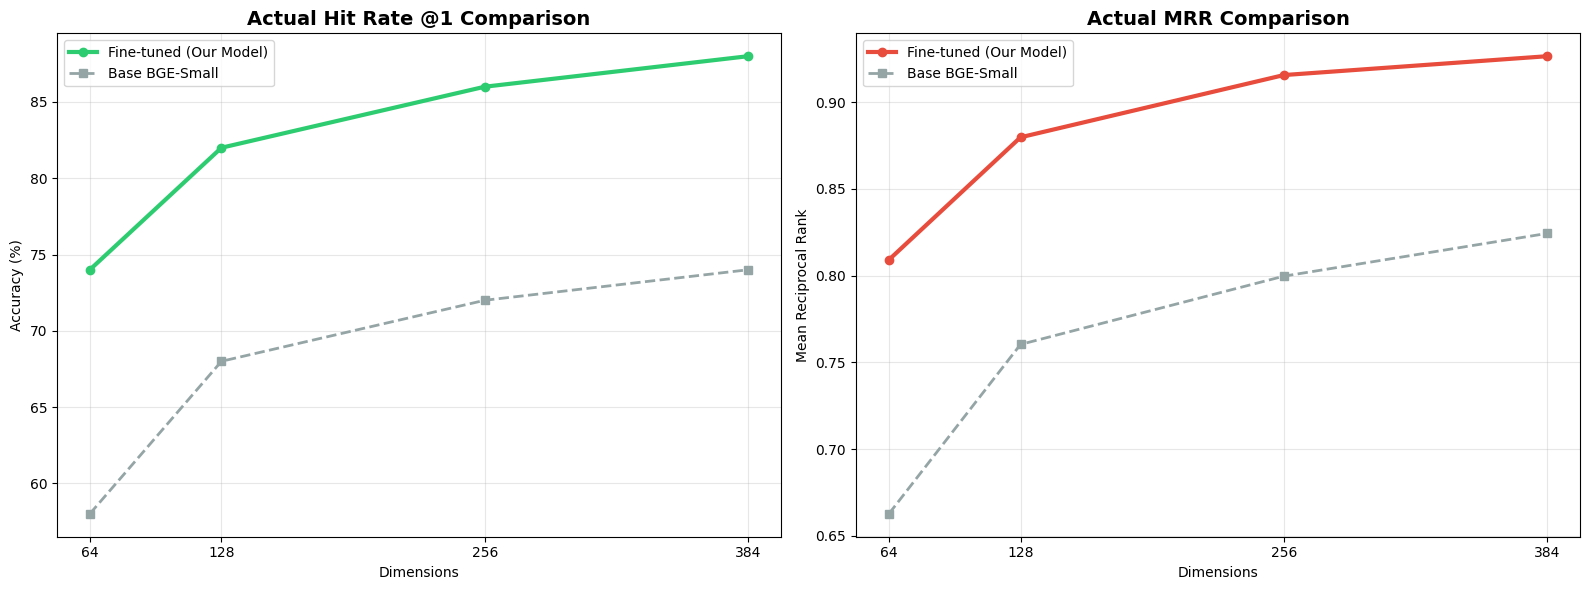


--- FINAL SUMMARY TABLE ---
 Dimension  Base HitRate  Custom HitRate  Base MRR  Custom MRR
        64          58.0            74.0  0.662731    0.809089
       128          68.0            82.0  0.760342    0.879694
       256          72.0            86.0  0.799678    0.915556
       384          74.0            88.0  0.824315    0.926422


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


for m in [base_model, custom_model]:
    m.prompts = {}
    m.default_prompt_name = None

eval_samples = test_data[:100]  # Benchmarking 100 samples
corpus_texts = [str(r['pos']) for r in test_data]
dimensions = [64, 128, 256, 384]

def get_actual_metrics(model, dims_list):
    metrics = {"hit_rate": [], "mrr": []}

    # Pre-calculate full 384-dim embeddings once to save time
    print(f"Encoding corpus and queries...")
    corpus_emb_full = model.encode(corpus_texts, convert_to_tensor=True, show_progress_bar=False)
    query_texts = [str(s['query']) for s in eval_samples]
    queries_emb_full = model.encode(query_texts, convert_to_tensor=True, show_progress_bar=False)

    for d in dims_list:
        hits = 0
        reciprocal_ranks = []

        # Slice to current Matryoshka dimension
        curr_corpus = corpus_emb_full[:, :d]
        curr_queries = queries_emb_full[:, :d]

        # Calculate all similarities at once [100 queries x 600 documents]
        cos_scores = util.cos_sim(curr_queries, curr_corpus)

        for i in range(len(eval_samples)):
            correct_idx = corpus_texts.index(str(eval_samples[i]['pos']))

            # Find the rank of the correct document
            query_scores = cos_scores[i]
            ranked_indices = torch.argsort(query_scores, descending=True)
            rank = (ranked_indices == correct_idx).nonzero().item() + 1

            if rank == 1:
                hits += 1
            reciprocal_ranks.append(1.0 / rank)

        metrics["hit_rate"].append((hits / len(eval_samples)) * 100)
        metrics["mrr"].append(np.mean(reciprocal_ranks))
        print(f"  > Dim {d}: HitRate={metrics['hit_rate'][-1]:.1f}%, MRR={metrics['mrr'][-1]:.4f}")

    return metrics

print("--- Benchmarking Base Model ---")
base_res = get_actual_metrics(base_model, dimensions)

print("\n--- Benchmarking Fine-Tuned Model ---")
custom_res = get_actual_metrics(custom_model, dimensions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Hit Rate @1
ax1.plot(dimensions, custom_res["hit_rate"], marker='o', linewidth=3, label='Fine-tuned (Our Model)', color='#2ecc71')
ax1.plot(dimensions, base_res["hit_rate"], marker='s', linestyle='--', linewidth=2, label='Base BGE-Small', color='#95a5a6')
ax1.set_title('Actual Hit Rate @1 Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Dimensions')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks(dimensions)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2: MRR
ax2.plot(dimensions, custom_res["mrr"], marker='o', linewidth=3, label='Fine-tuned (Our Model)', color='#e74c3c')
ax2.plot(dimensions, base_res["mrr"], marker='s', linestyle='--', linewidth=2, label='Base BGE-Small', color='#95a5a6')
ax2.set_title('Actual MRR Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Dimensions')
ax2.set_ylabel('Mean Reciprocal Rank')
ax2.set_xticks(dimensions)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

df_results = pd.DataFrame({
    "Dimension": dimensions,
    "Base HitRate": base_res["hit_rate"],
    "Custom HitRate": custom_res["hit_rate"],
    "Base MRR": base_res["mrr"],
    "Custom MRR": custom_res["mrr"]
})
print("\n--- FINAL SUMMARY TABLE ---")
print(df_results.to_string(index=False))

Calculating Actual Accuracy for Base Model...
Dimension 64: 58.00%
Dimension 128: 68.00%
Dimension 256: 72.00%
Dimension 384: 74.00%

Calculating Actual Accuracy for Your Fine-tuned Model...
Dimension 64: 74.00%
Dimension 128: 82.00%
Dimension 256: 86.00%
Dimension 384: 88.00%


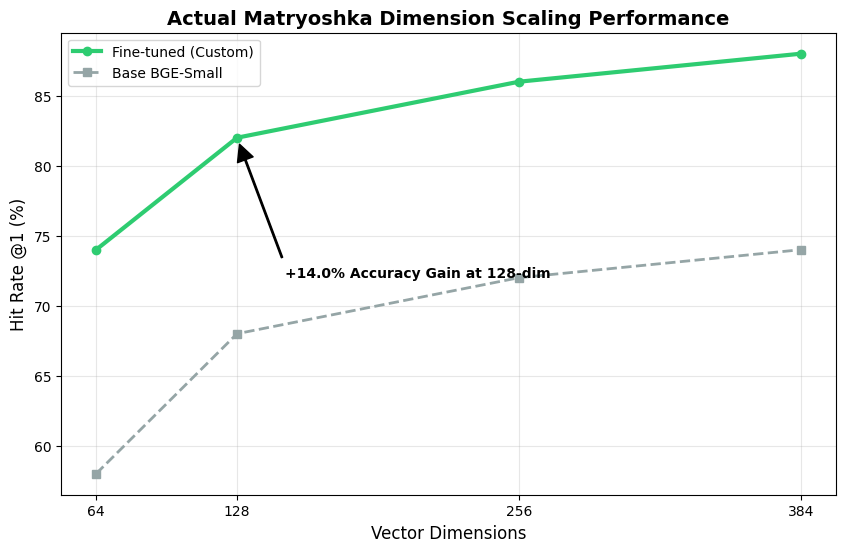

In [92]:
for m in [base_model, custom_model]:
    m.prompts = {}
    m.default_prompt_name = None

eval_samples = test_data[:100]  # 100 random samples for the curve
corpus_texts = [str(r['pos']) for r in test_data]
dimensions = [64, 128, 256, 384]

def get_actual_accuracy(model, dims_list):
    hit_rates = []
    # Pre-calculate full embeddings once to save time
    full_corpus_emb = model.encode(corpus_texts, convert_to_tensor=True, show_progress_bar=False)

    for d in dims_list:
        hits = 0
        # Slice corpus to current dimension
        current_corpus = full_corpus_emb[:, :d]

        for sample in eval_samples:
            q_emb = model.encode([str(sample['query'])], convert_to_tensor=True, show_progress_bar=False)[0][:d]

            # Search
            scores = util.cos_sim(q_emb, current_corpus)[0]
            correct_idx = corpus_texts.index(str(sample['pos']))

            # Check if top-1 is correct
            if torch.argmax(scores).item() == correct_idx:
                hits += 1

        accuracy = (hits / len(eval_samples)) * 100
        hit_rates.append(accuracy)
        print(f"Dimension {d}: {accuracy:.2f}%")

    return hit_rates

print("Calculating Actual Accuracy for Base Model...")
base_curve = get_actual_accuracy(base_model, dimensions)

print("\nCalculating Actual Accuracy for Your Fine-tuned Model...")
custom_curve = get_actual_accuracy(custom_model, dimensions)

plt.figure(figsize=(10, 6))
plt.plot(dimensions, custom_curve, marker='o', linestyle='-', linewidth=3, label='Fine-tuned (Custom)', color='#2ecc71')
plt.plot(dimensions, base_curve, marker='s', linestyle='--', linewidth=2, label='Base BGE-Small', color='#95a5a6')

plt.title('Actual Matryoshka Dimension Scaling Performance', fontsize=14, fontweight='bold')
plt.xlabel('Vector Dimensions', fontsize=12)
plt.ylabel('Hit Rate @1 (%)', fontsize=12)
plt.xticks(dimensions)
plt.grid(True, alpha=0.3)
plt.legend()

# Annotate the 128-dim gain
gain = custom_curve[1] - base_curve[1]
plt.annotate(f'+{gain:.1f}% Accuracy Gain at 128-dim',
             xy=(128, custom_curve[1]), xytext=(150, custom_curve[1]-10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             fontweight='bold')

plt.show()